Linear Regression MSE (Team Value): 3908664677782492.5, R2: 0.9301464937121706
Ridge MSE (Team Value): 3908609049445812.5, R2: 0.9301474878712215
Lasso MSE (Team Value): 3908664663463154.5, R2: 0.930146493968078
XGBoost MSE (Team Value): 3278350450050452.5, R2: 0.9414111230676793
Random Forest MSE (Team Value): 2992227077592721.5, R2: 0.946524562680619
KNN MSE (Team Value): 2344368729395771.0, R2: 0.9581027309119938
Cross-validation MSE (Team Value with KNN): 7776430086219480.0


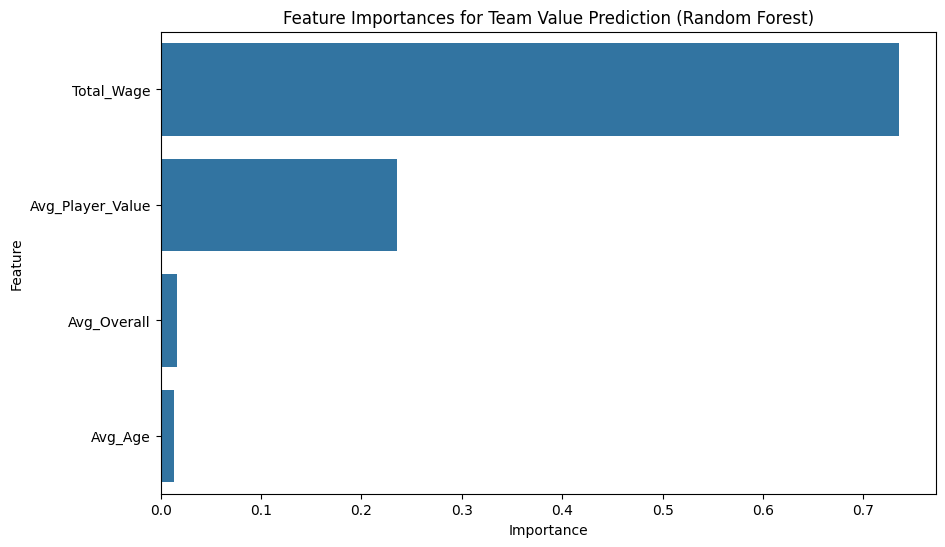

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

# Load the cleaned data
df = pd.read_csv('../Dataset/Cleaned/combinedCleanedData_20240709_145255.csv')

# Aggregate data by team
team_df = df.groupby('Club').agg({
    'Value': 'mean',
    'Overall': 'mean',
    'Wage': 'sum',
    'Age': 'mean'
}).reset_index()

team_df.rename(columns={
    'Value': 'Avg_Player_Value',
    'Overall': 'Avg_Overall',
    'Wage': 'Total_Wage',
    'Age': 'Avg_Age'
}, inplace=True)

# Define features and target for team value prediction
features_team_value = ['Avg_Player_Value', 'Avg_Overall', 'Total_Wage', 'Avg_Age']
X_team_value = team_df[features_team_value]
y_team_value = df.groupby('Club')['Value'].sum()

# Split data
X_train_team, X_test_team, y_train_team, y_test_team = train_test_split(X_team_value, y_team_value, test_size=0.2, random_state=42)

# Create a pipeline
def create_pipeline(model):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# Define models
models = {
    'Linear Regression': create_pipeline(LinearRegression()),
    'Ridge': create_pipeline(Ridge()),
    'Lasso': create_pipeline(Lasso()),
    'XGBoost': create_pipeline(XGBRegressor(random_state=42)),
    'Random Forest': create_pipeline(RandomForestRegressor(n_estimators=100, random_state=42)),
    'KNN': create_pipeline(KNeighborsRegressor(n_neighbors=5))
}

# Evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_team, y_train_team)
    y_pred = model.predict(X_test_team)
    mse = mean_squared_error(y_test_team, y_pred)
    r2 = r2_score(y_test_team, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name} MSE (Team Value): {mse}, R2: {r2}")

# Select the best model based on MSE
best_model_name = min(results, key=lambda x: results[x]['MSE'])
best_model = models[best_model_name]

# Cross-validation for the best model
cv_scores = cross_val_score(best_model, X_team_value, y_team_value, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation MSE (Team Value with {best_model_name}): {-cv_scores.mean()}")

# Use Random Forest to get feature importances
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_team, y_train_team)
importances = rf_model.feature_importances_
feature_names = X_team_value.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importances for Team Value Prediction (Random Forest)')
plt.show()


In [12]:
# Function to accept club name and make predictions
def predict_team_value_by_club(club_name):
    team_data = team_df[team_df['Club'] == club_name][features_team_value]
    if team_data.empty:
        print(f"Club {club_name} not found in the dataset.")
        return None
    prediction = best_model.predict(team_data)
    return prediction[0]

# Make predictions based on club name
club_name = input("Enter Club Name: ")
predicted_value = predict_team_value_by_club(club_name)
if predicted_value is not None:
    print(f"Predicted Team Value for {club_name}: {predicted_value}")

Predicted Team Value for Manchester United: 1682016200.0


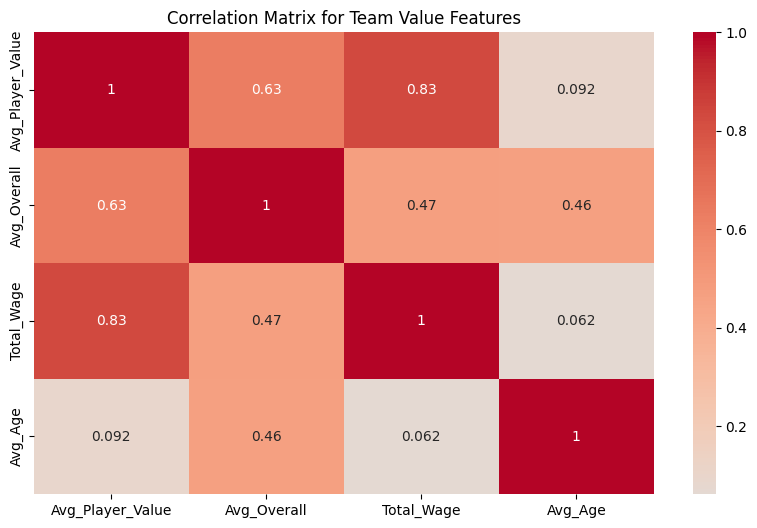

In [9]:
# Aggregate data by team
team_df = df.groupby('Club').agg({
    'Value': 'mean',
    'Overall': 'mean',
    'Wage': 'sum',
    'Age': 'mean'
}).reset_index()

team_df.rename(columns={
    'Value': 'Avg_Player_Value',
    'Overall': 'Avg_Overall',
    'Wage': 'Total_Wage',
    'Age': 'Avg_Age'
}, inplace=True)

# Calculate the correlation matrix
correlation_matrix = team_df[features_team_value].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for Team Value Features')
plt.show()

Your correlation matrix for the team value features looks good. It shows the relationships between average player value, average overall rating, total wage, and average age for each team. Here’s a brief explanation of what it shows:

Avg_Player_Value is strongly correlated with Total_Wage (0.83), indicating that teams with higher player values tend to have higher total wages.
Avg_Overall also shows a moderate correlation with Avg_Player_Value (0.63), suggesting that teams with higher overall ratings also tend to have higher player values.
Total_Wage is moderately correlated with Avg_Overall (0.47) and weakly correlated with Avg_Age (0.062), showing that wages are influenced by overall ratings but less by the average age of players.
Avg_Age has the lowest correlations with other features, indicating that the average age of players does not significantly impact player value, overall rating, or total wages.
Explanation of Correlation Matrix vs. Feature Importance
Correlation Matrix:

Purpose: It provides an overview of the relationships between pairs of features in your dataset.
Use Case: It helps understand how features are related to each other and can indicate potential multicollinearity issues in regression models.
Nature: Symmetric matrix where each cell represents the correlation coefficient between two features. Values range from -1 (perfect negative correlation) to 1 (perfect positive correlation).
Feature Importance:

Purpose: It shows how much each feature contributes to the prediction power of a machine learning model.
Use Case: It helps in understanding which features are most influential in making predictions and can guide feature selection and model tuning.
Nature: Typically presented as a list or bar plot, showing the importance score for each feature, which can be derived from models like Random Forest, XGBoost, etc.
Summary of Your Model Results:
Linear Regression: MSE: 3908664677782492.5, R2: 0.9301
Ridge Regression: MSE: 3908609049445812.5, R2: 0.9301
Lasso Regression: MSE: 3908664663463154.5, R2: 0.9301
XGBoost: MSE: 3278350450050452.5, R2: 0.9414
Random Forest: MSE: 2992227077592721.5, R2: 0.9465
KNN: MSE: 2344368729395771.0, R2: 0.9581
Cross-validation (KNN): MSE: 7776430086219480.0